In [1]:
import pandas as pd
import transliterate
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime
from feature_engine.selection import DropFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def date_features(df):
    df['visit_date'] = pd.to_datetime(df['visit_date'])
    df['Year'] = df['visit_date'].dt.year
    df['Month'] = df['visit_date'].dt.month
    df['Day'] = df['visit_date'].dt.day
    return df


def utm_features(df):
    df['utm_source'].fillna(df['utm_source'].mode()[0], inplace=True)
    social_media_sources = ('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
                            'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm')
    df['utm_source_is_social'] = df['utm_source'].isin(social_media_sources).astype(int)
    df['utm_campaign'].fillna(df['utm_campaign'].mode()[0], inplace=True)
    df['utm_adcontent'].fillna(df['utm_adcontent'].mode()[0], inplace=True)
    df['utm_keyword'].fillna(df['utm_keyword'].mode()[0], inplace=True)
    return df


def device_brand(df):
    df['device_brand'].fillna('other', inplace=True)
    return df

def time_features(df):
    df['visit_time'] = pd.to_datetime(df['visit_time'], format='%H:%M:%S')
    df['hour'] = df['visit_time'].dt.hour
    df['minute'] = df['visit_time'].dt.minute
    return df

def screen_features(df):
    df['screen_width'] = df['device_screen_resolution'].str.split('x').str[0].astype(int)
    df['screen_height'] = df['device_screen_resolution'].str.split('x').str[1].astype(int)
    return df
def screen_features2(df):
    df['device_screen_area'] = df['screen_width'] * df['screen_height']
    df['device_screen_ratio'] = df['screen_width'] / df['screen_height']
    return df
def typisation(df):
    df['Year'] = df['Year'].astype('int64')
    df['Month'] = df['Month'].astype('int64')
    df['Day'] = df['Day'].astype('int64')
    df['hour'] = df['hour'].astype('int64')
    df['minute'] = df['minute'].astype('int64')
    return df

def replace_numeric_with_most_common(df):
    most_common_value = df['geo_city'].mode().iloc[0]
    regex_filter = df['geo_city'].str.match(r'^-?\d+(\.\d+)?$')
    df.loc[regex_filter, 'geo_city'] = most_common_value

    return df

def low_reg(df):
    df = df.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
    return df
def translit(df):
    def transliterate_text(text):
        return transliterate.translit(text, 'ru', reversed=True)
    df['geo_city'] = df['geo_city'].apply(lambda x: transliterate_text(x) if isinstance(x, str) else x)
    return df
def delete_outliers(df):
    winsorizer = Winsorizer(capping_method='iqr', fold=0.2)

# Список столбцов, в которых нужно удалить выбросы
    columns_to_winsorize = ['screen_height', 'screen_width']

# Применение Winsorizer к каждому столбцу
    for column in columns_to_winsorize:
        df[column] = winsorizer.fit_transform(df[[column]])
    return df

def drop_duplicates(df):
    df = df.drop_duplicates()
    return df
def load_data():
    df_sessions = pd.read_csv('/Users/andreypronin/DataspellProjects/pythonProject/ga_sessions.csv', low_memory=False)
    df_hits = pd.read_csv("/Users/andreypronin/DataspellProjects/pythonProject/ga_hits.csv", usecols=['session_id', 'event_action'], low_memory=False)
    target_events = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
                    'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click',
                    'sub_submit_success', 'sub_car_request_submit_click']
    df_hits['target'] = df_hits['event_action'].isin(target_events)
    is_target_event = df_hits.groupby('session_id')['target'].any().astype(int)
    df = df_sessions.merge(is_target_event, on='session_id', how='inner')
    df['target'] = df['target'].fillna(1)
    return df

def drop_col(df):
    col_to_drop = ['session_id', 'client_id', 'visit_date',
                   'visit_time', 'device_screen_resolution', 'device_model', 'device_os']
    df = df.drop(col_to_drop)
    return df


In [2]:
numerical = make_column_selector(dtype_include=['int64', 'float64', 'int32'])
categorical = make_column_selector(dtype_include=['category'])

#обработка числовых
std_scaler = StandardScaler()
imputer = SimpleImputer(strategy='most_frequent')
pipe_num = Pipeline([
    ('imputer', imputer),
    ('scaler', std_scaler)])

#обработка категориальных
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
pipe_cat = Pipeline([('encoder', ohe_encoder)])
preprocessor_features = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical),
    ('category', pipe_cat, categorical)
])
#Гиперпараметры подбирались в отдельном файле, но он был с множеством недочетов, поэтому гиперпараметры я оставил такие, а файл решил не включать в итог.
#Градиентный бустинг не проходился в курсе, но он рекомендуется при сильном дизбалансе классов.
models = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(solver='saga', C=10), #Solver saga для решения данной задачи является лучшим вариантом
    },
    {
        'name': 'RandomForestClassifier',
        'model': RandomForestClassifier(max_depth=10, n_estimators=200),
    },
    {
        'name': 'MLPClassifier',
        'model': MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50)),
    },
    {
        'name': 'GradientBoostingClassifier', #Не проходился в курсе, но для предсказания таргета при сильном дизбалансе классов, советуют в том числе эту модель, поэтому попробую реализовать
        'model': GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1),
    }
]

best_score = 0
best_pipe = None

for model_info in models:
    model = model_info['model']

    pipe = Pipeline(steps=[
        ('date_features', FunctionTransformer(date_features)),
        ('utm_source', FunctionTransformer(utm_features)),
        ('device_brand', FunctionTransformer(device_brand)),
        ('time_features', FunctionTransformer(time_features)),
        ('screen_features', FunctionTransformer(screen_features)),
        ('delete_outliers', FunctionTransformer(delete_outliers)),
        ('screen_2', FunctionTransformer(screen_features2)),
        ('replace_numeric', FunctionTransformer(replace_numeric_with_most_common)),
        ('typisation', FunctionTransformer(typisation)),
        ('low_reg', FunctionTransformer(low_reg)),
        ('translit', FunctionTransformer(translit)),
        ('drop_duplicates', FunctionTransformer(drop_duplicates)),
        ('dropper', DropFeatures(['session_id', 'client_id', 'visit_date',
                                  'visit_time', 'device_screen_resolution', 'device_model', 'device_os'])),
        ('preprocessor_features', preprocessor_features),
        ('classifier', model)
    ])

    df = load_data()

    X = df.drop('target', axis=1)
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f'model: {model_info["name"]}, roc_auc: {roc_auc:.4f}')

    if roc_auc > best_score:
        best_score = roc_auc
        best_pipe = pipe

/Users/andreypronin/anaconda3/envs/pythonProject/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


model: LogisticRegression, roc_auc: 0.6062
model: RandomForestClassifier, roc_auc: 0.6494
model: MLPClassifier, roc_auc: 0.6437
model: GradientBoostingClassifier, roc_auc: 0.6541


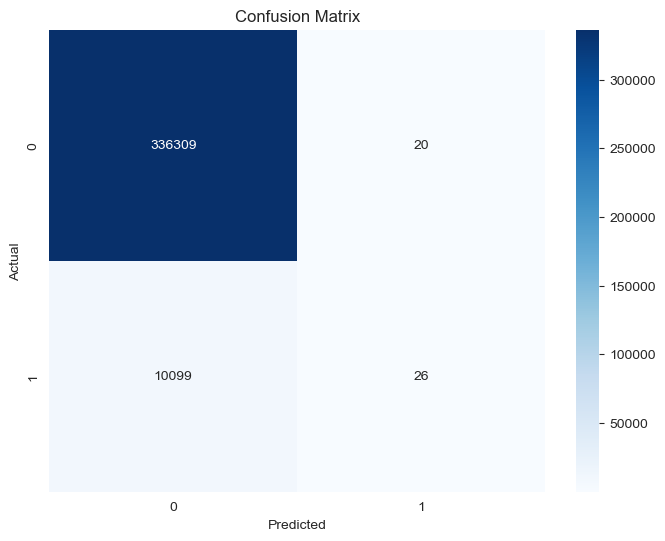

In [3]:
y_pred = best_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

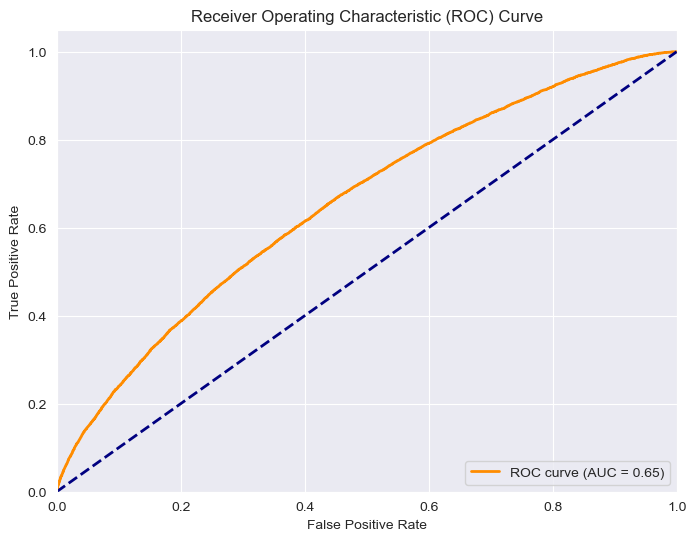

In [4]:
y_proba = best_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()